In [273]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

In [460]:
#Load Datasets

## load Cleaned Data
cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")
cleaned_data.index = cleaned_data.index.astype(int)

#load Energy Equity Project Data
eep_data = pd.read_csv("data/eep_final_data.csv", index_col="GEOID")
eep_data.index = eep_data.index.astype(int)

## load solar adoption data
adoption_data = pd.read_csv('data/solar_demographic_tract_level_data.csv', index_col=0)
adoption_data = adoption_data.rename(columns={'tract': 'GEOID'})

## load geospatial data
tracts_geodata = gpd.read_file('tracts.geojson')
tracts_geodata = tracts_geodata.set_index('GEOID')
tracts_geodata.index = tracts_geodata.index.astype(int)

/var/folders/67/r87g720s2653g554zdhtz1vh0000gn/T/ipykernel_1648/3565819471.py:4: DtypeWarning: Columns (181) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")


In [556]:
#Fix data types
adoption_data['bin_description'] = adoption_data['bin_description'].astype(str)

#Filter out data for only income by AMI bin
ami_adoption_data = adoption_data[adoption_data['bin_description'].str.contains('AMI Bin:')]
print("# of Census Tracts in original dataset: "+str(len(ami_adoption_data['GEOID'].unique())))

grouped_adoption_data = ami_adoption_data.groupby(['GEOID', 'year']).sum().reset_index()

#Merge population from cleaned data to adoption dataset
all_data = grouped_adoption_data.merge(eep_data['total_pop'], left_on='GEOID', right_index=True)
print("# of Census Tracts in total : "+str(len(all_data['GEOID'].unique())))

combined_data = grouped_adoption_data.merge(cleaned_data[['total_pop', 'yearly_sunlight_kwh_median', 'kw_median' ]], left_on='GEOID', right_index=True)
print("# of Census Tracts after merging : "+str(len(combined_data['GEOID'].unique())))

merged_data = grouped_adoption_data.merge(cleaned_data[['total_pop', 'yearly_sunlight_kwh_median', 'kw_median', 'county_name', 'state_abbr' ]], how='right', left_on='GEOID', right_index=True)

# Calculate the adoption rate for each year
combined_data['adoption_rate'] = combined_data['N'] / combined_data['total_pop'] * 100
all_data['adoption_rate'] = all_data['N'] / all_data['total_pop'] * 100
merged_data['adoption_rate'] = merged_data['N'] / merged_data['total_pop'] * 100

print(combined_data.head)

# of Census Tracts in original dataset: 17008
# of Census Tracts in total : 13589
# of Census Tracts after merging : 5145
<bound method NDFrame.head of              GEOID  year                                    bin_description   
2       4005000400  2021  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...  \
39      4013040506  2010  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
40      4013040506  2011  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
41      4013040506  2012  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
42      4013040506  2013  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
...            ...   ...                                                ...   
73374  53077003400  2020  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
73381  55025000902  2021  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
73385  55025002603  2019  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
73386  55025002603  2021  AMI Bin: <60%AMI Bin: 60-80%AMI 

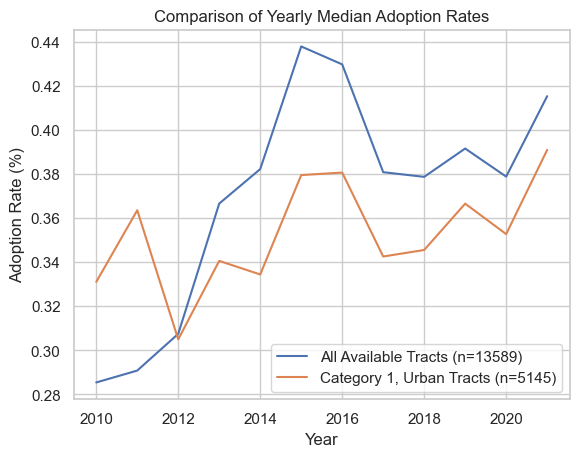

In [486]:
#Plot adoption rates comparing all data with selected data
all_data_grouped = all_data.groupby('year')['adoption_rate'].median()
combined_data_grouped = combined_data.groupby('year')['adoption_rate'].median()

plt.plot(all_data_grouped.index, all_data_grouped.values, label='All Available Tracts (n=13589)')
plt.plot(combined_data_grouped.index, combined_data_grouped.values, label='Category 1, Urban Tracts (n=5145)')

plt.xlabel('Year')
plt.ylabel('Adoption Rate (%)')
plt.title('Comparison of Yearly Median Adoption Rates')
plt.legend()


In [500]:
print(combined_data.loc[combined_data['GEOID']== 41067031403])

             GEOID  year                                    bin_description   
67474  41067031403  2021  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...  \

         pct   N  total_pop  yearly_sunlight_kwh_median  kw_median   
67474  100.1  18     4913.0                 11721.20138      11.75  \

       adoption_rate  
67474       0.366375  


count    15063.000000
mean         0.457333
std          0.369335
min          0.088984
25%          0.256739
50%          0.365749
75%          0.544611
max         10.251256
Name: adoption_rate, dtype: float64
coefficient of determination: 0.0010361483978904573
intercept: [-12.91075003]
slope: [[0.00662221]]


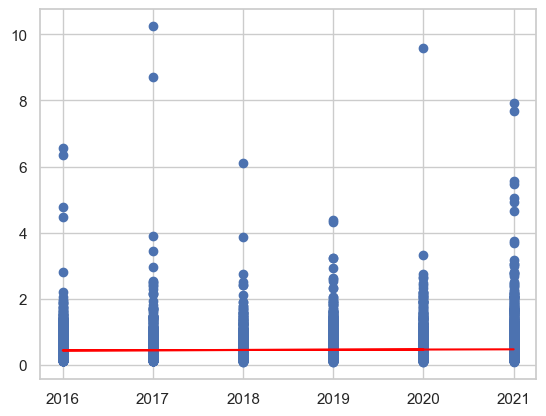

In [452]:
#Linear Regression for all data

filtered_data = combined_data[combined_data['year'] >= 2016]

print(filtered_data['adoption_rate'].describe())
plt.scatter(filtered_data['year'], filtered_data['adoption_rate'])

X = filtered_data['year'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = filtered_data['adoption_rate'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_model = LinearRegression().fit(X, Y)   # create object for the class and # perform linear regression
Y_pred = linear_model.predict(X)  # make predictions
#print(merged_urban['kw_median'].median())

print(f"coefficient of determination: {linear_model.score(X, Y)}")
print(f"intercept: {linear_model.intercept_}")
print(f"slope: {linear_model.coef_}")

plt.plot(X, Y_pred, color='red')
# plt.ylim(0.4, 0.5)

[7.61134772 7.60589    7.60638739 ... 7.61035762 7.61134772 7.61085279]
[[  3.65802934]
 [-27.37840517]]


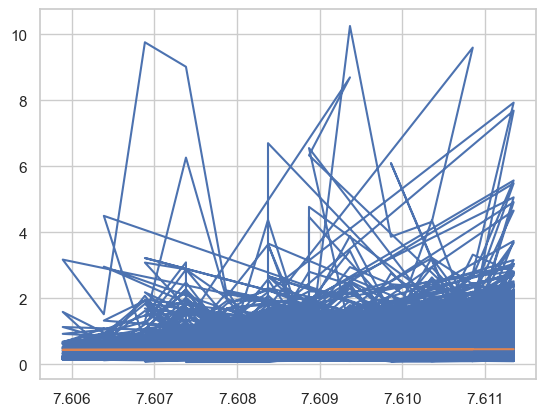

In [442]:
#Exponential for all data
#plt.scatter(combined_data['year'], combined_data['adoption_rate'])

x = combined_data['year'].values.reshape(-1, 1)  # values converts it into a numpy array
y = combined_data['adoption_rate'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
xlog = np.log(x).flatten()
print(xlog)
curve = np.polyfit(xlog, y, 1)
print(curve)
y_pred = 3.65802934 * xlog -27.37840517
plt.plot(xlog, y)
plt.plot(xlog, y_pred)

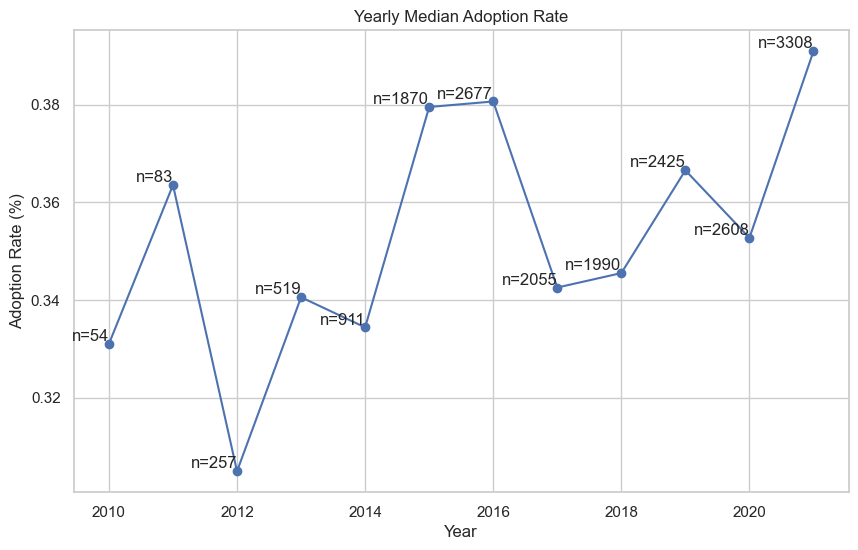

In [216]:
#Plot adoption rate

grouped_data = combined_data.groupby(['bin_description', 'year'])['adoption_rate'].median().reset_index()

grouped_data_count = combined_data.groupby(['bin_description', 'year'])['adoption_rate'].count().reset_index()
# grouped_data = combined_data[combined_data['GEOID'] == 4013040506]

plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
for bin_desc in grouped_data['bin_description'].unique():
    bin_data = grouped_data[grouped_data['bin_description'] == bin_desc]
    plt.plot(bin_data['year'], bin_data['adoption_rate'], marker='o', label=bin_desc)

# Annotate each data point with the corresponding count
    for idx, row in bin_data.iterrows():
        count = grouped_data_count[(grouped_data_count['bin_description'] == row['bin_description']) & 
                                   (grouped_data_count['year'] == row['year'])]['adoption_rate'].values[0]
        plt.text(row['year'], row['adoption_rate'], f'n={count}', ha='right', va='bottom')


plt.xlabel('Year')
plt.ylabel('Adoption Rate (%)')
plt.title('Yearly Median Adoption Rate')
# plt.legend(title='Income Category')
plt.grid(True)  # Optional: Show gridlines
# plt.show()

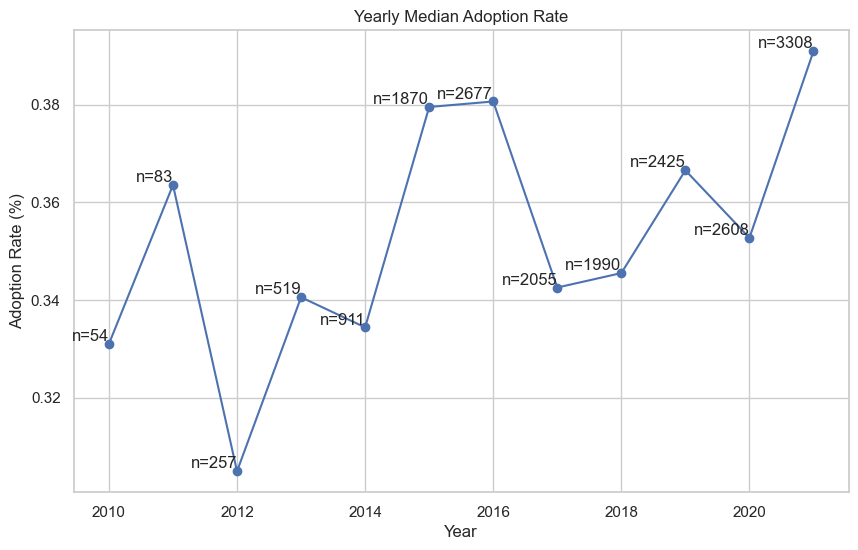

In [266]:
#Plot adoption rate

grouped_data = combined_data.groupby(['bin_description', 'year'])['adoption_rate'].median().reset_index()

grouped_data_count = combined_data.groupby(['bin_description', 'year'])['adoption_rate'].count().reset_index()
# grouped_data = combined_data[combined_data['GEOID'] == 4013040506]

plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
for bin_desc in grouped_data['bin_description'].unique():
    bin_data = grouped_data[grouped_data['bin_description'] == bin_desc]
    plt.plot(bin_data['year'], bin_data['adoption_rate'], marker='o', label=bin_desc)

# Annotate each data point with the corresponding count
    for idx, row in bin_data.iterrows():
        count = grouped_data_count[(grouped_data_count['bin_description'] == row['bin_description']) & 
                                   (grouped_data_count['year'] == row['year'])]['adoption_rate'].values[0]
        plt.text(row['year'], row['adoption_rate'], f'n={count}', ha='right', va='bottom')


plt.xlabel('Year')
plt.ylabel('Adoption Rate (%)')
plt.title('Yearly Median Adoption Rate')
# plt.legend(title='Income Category')
plt.grid(True)  # Optional: Show gridlines
# plt.show()

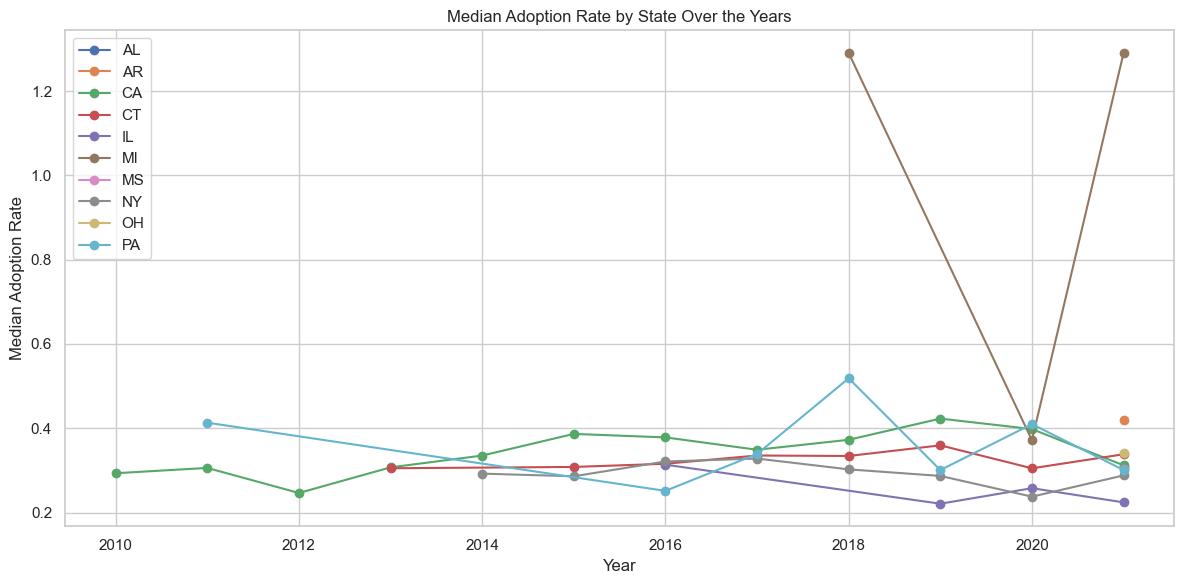

In [244]:
# Get the top 10 states based on the median adoption rate in 2021
selected_states = ['IL', 'OH', 'MI', 'MS', 'AL', 'PA', 'NY', 'CT', 'AR' ,'CA']

# Filter the data for the top 10 states
top_10_states_data = combined_data[combined_data['state_abbr'].isin(selected_states)]


# Calculate the median adoption rate for each state over the years
median_adoption_rate_by_state_year = top_10_states_data.groupby(['state_abbr', 'year'])['adoption_rate'].median().reset_index()

# Create a figure and axis for the plot
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the median adoption rate for each state as a line graph
for state in median_adoption_rate_by_state_year['state_abbr'].unique():
    state_data = median_adoption_rate_by_state_year[median_adoption_rate_by_state_year['state_abbr'] == state]
    plt.plot(state_data['year'], state_data['adoption_rate'], marker='o', label=state)

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Median Adoption Rate')
plt.title('Median Adoption Rate by State Over the Years')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [390]:
#Extrapolate Data - Exponential Regression

import numpy as np
from scipy.optimize import curve_fit

# Extrapolate adoption rate using exponential regression
def extrapolate_adoption_rate(x, a, b, c):
    return a * np.exp(b * (x - 2021)) + c

# Create a DataFrame to store the extrapolated data
extrapolated_data = pd.DataFrame(columns=['GEOID', 'year', 'adoption_rate'])

# Group the data by 'GEOID' and fit the exponential regression to all adoption rate data
filtered_data = combined_data[combined_data['year'] >= 2015]
x = filtered_data['year'].values
y = filtered_data['adoption_rate'].values

# Filter out any NaN or infinite values in x and y
mask = ~np.isnan(x) & ~np.isnan(y) & np.isfinite(x) & np.isfinite(y)
x_filtered = x[mask]
y_filtered = y[mask]

min_year = x_filtered.min()

# Define the exponential function to fit the data
def exponential_func(x, a, b, c):
    return a * np.exp(b * (x - min_year)) + c

# Provide initial guesses for parameters a, b, and c based on the data
# p0 = (y_filtered[0], 0.0001, 0)  # Initial guess for parameters: (a, b, c)

p0 = (10, 0.0001, 0)  # Initial guess for parameters: (a, b, c)


# Fit the exponential model to the data using curve_fit
popt, _ = curve_fit(exponential_func, x_filtered, y_filtered, p0=p0, maxfev=10000)

# Extrapolate from 2021 to 2025
future_years = np.arange(2021, 2050)
predictions = exponential_func(future_years, *popt)

# Repeat GEOID values for each year
unique_geoids = combined_data['GEOID'].unique()
extrapolated_data['GEOID'] = np.repeat(unique_geoids, len(future_years))
extrapolated_data['year'] = np.tile(future_years, len(unique_geoids))
extrapolated_data['adoption_rate'] = np.tile(predictions, len(unique_geoids))

# Combine original data and extrapolated data
predicted_adoption_data = pd.concat([interpolated_data, extrapolated_data], ignore_index=True, join='outer').ffill()

# Print the extrapolated DataFrame
print(predicted_adoption_data)
print(predicted_adoption_data.isna().sum())







              GEOID    year   
0       53067010600  2021.0  \
1       53067011500  2021.0   
2       53067011300  2021.0   
3       53067011200  2021.0   
4       53067010920  2021.0   
...             ...     ...   
715607   6071003404  2045.0   
715608   6071003404  2046.0   
715609   6071003404  2047.0   
715610   6071003404  2048.0   
715611   6071003404  2049.0   

                                          bin_description    pct     N   
0       AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...  100.0  25.0  \
1       AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...  100.0  25.0   
2       AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...  100.0  25.0   
3       AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...  100.0  25.0   
4       AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...  100.0  25.0   
...                                                   ...    ...   ...   
715607  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   99.9  12.0   
715608  AMI Bin: <60%AMI Bin: 60-80

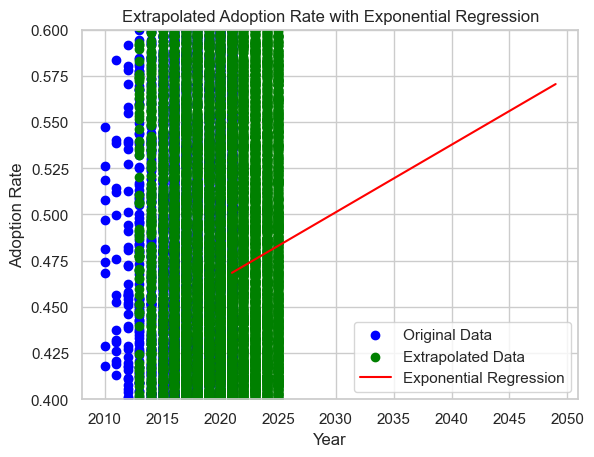

In [433]:
import matplotlib.pyplot as plt

# Plot the original data points
plt.scatter(combined_data['year'], combined_data['adoption_rate'], label='Original Data', color='blue')

# Plot the extrapolated data points
plt.scatter(extrapolated_data['year'], extrapolated_data['adoption_rate'], label='Extrapolated Data', color='green')

# Plot the exponential regression curve
plt.plot(future_years, predictions, label='Exponential Regression', color='red')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Adoption Rate')
plt.title('Extrapolated Adoption Rate with Exponential Regression')
plt.legend()
plt.ylim(0.4, 0.6)
# Show the plot
plt.show()


In [695]:
#Fill in adoption rate for missing tracts

interpolated_data = merged_data.copy()

# Calculate the median adoption rate for each county in 2021
data_2021 = interpolated_data[interpolated_data['year'] == 2021]

median_adoption_rate_by_county_2021 = data_2021.groupby('county_name')['adoption_rate'].median()

# Calculate the median adoption rate for each state in 2021
median_adoption_rate_by_state_2021 = data_2021.groupby('state_abbr')['adoption_rate'].median()

# Calculate the median adoption rate for the entire 'interpolated_data' DataFrame for the year 2021
median_adoption_rate_2021 = data_2021['adoption_rate'].median()

# Fill in the missing adoption rate for each census tract in 2021 with the median adoption rate of its county or state in 2021
interpolated_data['adoption_rate'] = interpolated_data['adoption_rate'].fillna(
    interpolated_data.apply(
    lambda row: median_adoption_rate_by_county_2021[row['county_name']]
    if row['county_name'] in median_adoption_rate_by_county_2021.index
    else median_adoption_rate_by_state_2021[row['state_abbr']]
    if row['state_abbr'] in median_adoption_rate_by_state_2021.index
    else None,
    axis=1
    )
)
interpolated_data['year'] = interpolated_data['year'].fillna(2021)

print(interpolated_data.isna().sum())
alltracts = set(interpolated_data['GEOID'].unique())
with2021 = set(interpolated_data[interpolated_data['year'] == 2021]['GEOID'].unique())
without2021 = alltracts.difference(with2021)

print(f"# of Census Tracts: {len(with2021)}")
print(f"# of Census Tracts without 2021 data: {len(without2021)}")
print(f"# of Census Tracts Total: {len(interpolated_data['GEOID'].unique())}")

print(interpolated_data.sort_values('year'))


GEOID                             0
year                              0
bin_description               18255
pct                           18255
N                             18255
total_pop                         0
yearly_sunlight_kwh_median        0
kw_median                         0
county_name                       0
state_abbr                        0
adoption_rate                  2899
dtype: int64
# of Census Tracts: 21563
# of Census Tracts without 2021 data: 1837
# of Census Tracts Total: 23400
               GEOID    year   
14520.0   6037575001  2010.0  \
2688.0    4013813700  2010.0   
8051.0    6019000901  2010.0   
233.0     4013040529  2010.0   
35546.0   6087100200  2010.0   
...              ...     ...   
NaN      47125102004  2021.0   
NaN      47125102003  2021.0   
NaN      47125101001  2021.0   
NaN      19193001100  2021.0   
NaN      45015020806  2021.0   

                                           bin_description    pct     N   
14520.0  AMI Bin: <60%AMI Bin:

GEOID
4013082010     1.0
4013103210     4.0
4013104218     6.0
4013104502     4.0
4013107300     1.0
              ... 
53061050900    1.0
53063002300    1.0
53077001602    1.0
53077003400    3.0
55025011506    1.0
Name: year, Length: 1837, dtype: float64


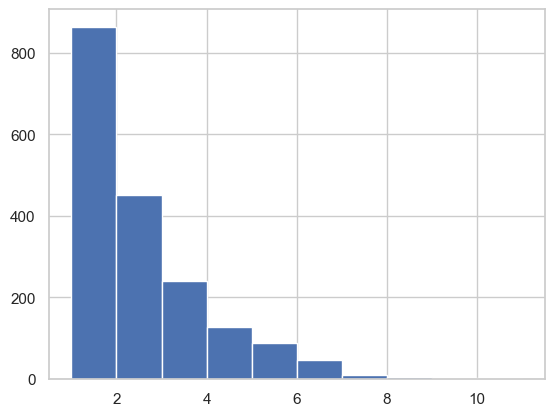

In [576]:
#for the GEOIDs that don't have 2021 data, how many data pt do they have?
grouped_data = interpolated_data.groupby('GEOID')

# Find GEOIDs that don't have the year '2021' and count the number of other years they have
missing_2021_years = grouped_data['year'].agg(lambda x: x[x != 2021].nunique() if 2021 not in x.values else None)

missing_2021_years.dropna(inplace=True)

plt.hist(missing_2021_years.values)

print(missing_2021_years)


In [696]:
#Predict future years and scenarios adoption rates
future_years = np.arange(2022, 2034)

scenario_percentages = {
    'bau': 1.0075,
    'med': 1.02,
    'high': 1.04
}

# function for exponential function modeling adoption y=(adopt_r)^change_p(i)
def exponential(x, adopt_r, change_p):
    return [adopt_r*(change_p ** i) for i in np.arange(0, len(x))]

# Create an empty list to store the results
extrapolated_data_list = []

# Iterate through scenario_percentages
for scenario, percentage in scenario_percentages.items():
    extrapolated_data = interpolated_data[interpolated_data['year'] == 2021].groupby('GEOID').apply(
        lambda group_data: pd.DataFrame({
            'GEOID': group_data['GEOID'].iloc[0],
            'year': future_years,
            'adoption_rate': exponential(future_years, group_data['adoption_rate'].iloc[0], percentage),
            'scenario': scenario
        })
    )
    extrapolated_data_list.append(extrapolated_data)

# Combine original data and extrapolated data
predicted_adoption_data = pd.concat([interpolated_data] + extrapolated_data_list, ignore_index=True)

#Set older data to 'bau' scenario
predicted_adoption_data['scenario'] = predicted_adoption_data['scenario'].fillna('bau')
#Sort by GEOID, reset index and propogate other column values to other rows
predicted_adoption_data = predicted_adoption_data.sort_values(by=['GEOID','year']).reset_index().ffill()

# Create a boolean mask to remove 'year' == 2022 and 'scenario' is 'high' or 'med'
condition = (predicted_adoption_data['year'] == 2022) & (predicted_adoption_data['scenario'].isin(['high', 'med']))
# Drop the rows that satisfy the condition
predicted_adoption_data = predicted_adoption_data.loc[~(condition)]



<bound method NDFrame.head of year    scenario
2010.0  bau         0.331014
2011.0  bau         0.363535
2012.0  bau         0.304936
2013.0  bau         0.340557
2014.0  bau         0.334395
2015.0  bau         0.379514
2016.0  bau         0.380642
2017.0  bau         0.342550
2018.0  bau         0.345509
2019.0  bau         0.366544
2020.0  bau         0.352713
2021.0  bau         0.341569
2022.0  bau         0.341569
2023.0  bau         0.344131
        high        0.355232
        med         0.348400
2024.0  bau         0.346712
        high        0.365172
        med         0.355368
2025.0  bau         0.349312
        high        0.373509
        med         0.362476
2026.0  bau         0.351932
        high        0.385956
        med         0.365453
2027.0  bau         0.354571
        high        0.401395
        med         0.372762
2028.0  bau         0.357231
        high        0.417450
        med         0.373509
2029.0  bau         0.359910
        high        0.434

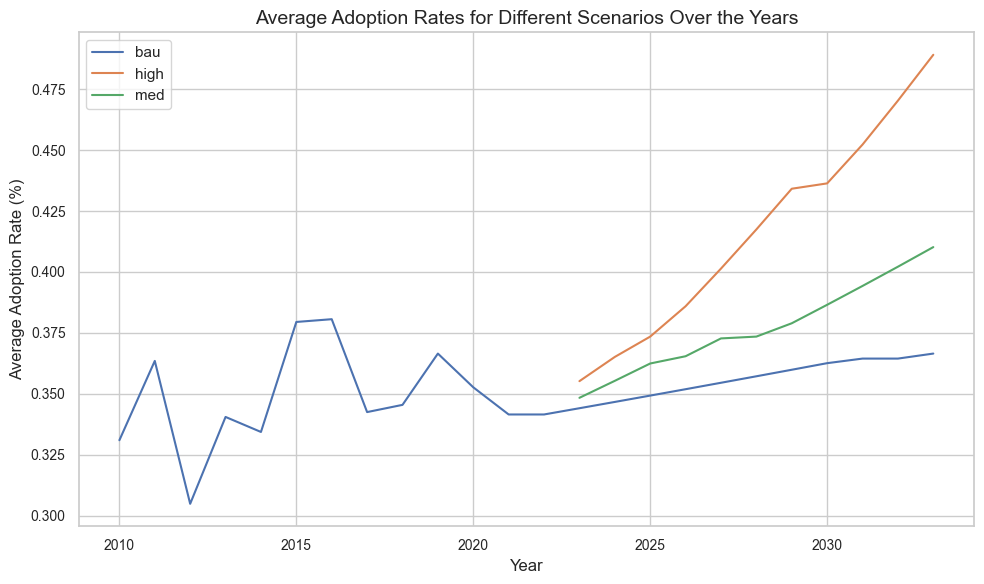

In [697]:
#Map Average adoption rates for each scenario and year

# Calculate the average adoption rates for each scenario and year
average_adoption_rates = predicted_adoption_data.groupby(['year', 'scenario'])['adoption_rate'].median()

print(average_adoption_rates.head)

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot average adoption rates for each scenario
for scenario in average_adoption_rates.index.get_level_values('scenario').unique():
    ax.plot(average_adoption_rates.loc[:, scenario], label=scenario)

# Customize gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Adoption Rate (%)', fontsize=12)
plt.title('Average Adoption Rates for Different Scenarios Over the Years', fontsize=14)

# Customize font size for tick labels and legend
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()




In [739]:
#Calculate generation and capcity per tract
predicted_generation_data = predicted_adoption_data.copy()
predicted_generation_data['kw'] = predicted_generation_data['adoption_rate']/100 * predicted_generation_data['total_pop']  * predicted_generation_data['kw_median']
predicted_generation_data['yearly_kwh'] = predicted_generation_data['adoption_rate']/100 * predicted_generation_data['total_pop'] * predicted_generation_data['yearly_sunlight_kwh_median']


<bound method NDFrame.head of year    scenario
2010.0  bau         0.012830
2011.0  bau         0.022499
2012.0  bau         0.065755
2013.0  bau         0.147573
2014.0  bau         0.232818
2015.0  bau         0.509063
2016.0  bau         0.687118
2017.0  bau         0.521606
2018.0  bau         0.494374
2019.0  bau         0.651432
2020.0  bau         0.675368
2021.0  bau         3.377419
2022.0  bau         3.377419
2023.0  bau         3.399206
        high        3.493616
        med         3.435518
2024.0  bau         3.421157
        high        3.614461
        med         3.494778
2025.0  bau         3.443271
        high        3.740139
        med         3.555224
2026.0  bau         3.465552
        high        3.870845
        med         3.616878
2027.0  bau         3.488000
        high        4.006778
        med         3.679766
2028.0  bau         3.510616
        high        4.148149
        med         3.743911
2029.0  bau         3.533402
        high        4.295

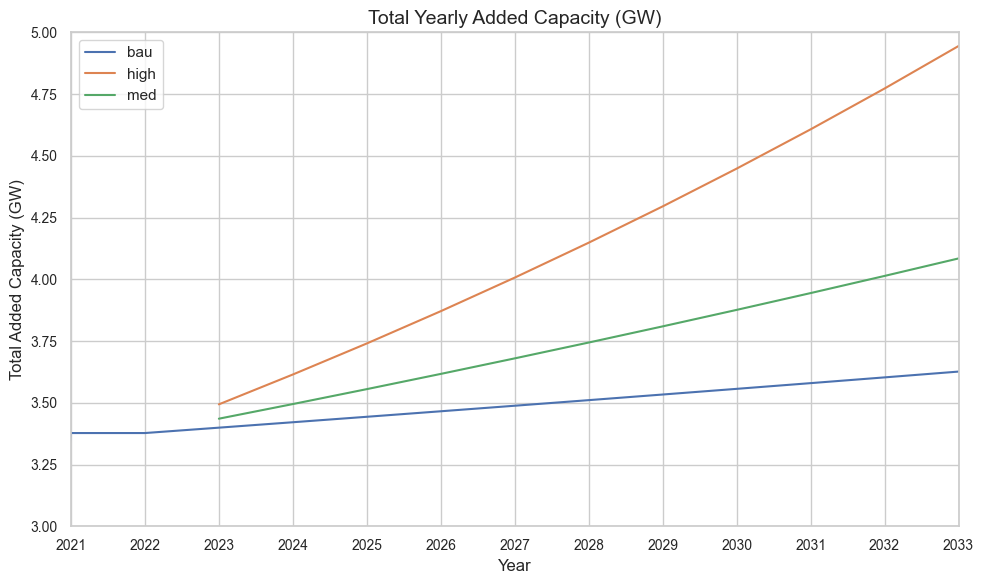

In [723]:

# Calculate the total capacity for each scenario and year
total_capacity = predicted_generation_data.groupby(['year', 'scenario'])['kw'].sum()/1000000
print(total_capacity.head)

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot average adoption rates for each scenario
for scenario in total_capacity.index.get_level_values('scenario').unique():
    ax.plot(total_capacity.loc[:, scenario], label=scenario)

# Customize gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Added Capacity (GW)', fontsize=12)
plt.title('Total Yearly Added Capacity (GW)', fontsize=14)

# Customize font size for tick labels and legend
plt.xticks(total_generation.index.get_level_values('year').unique(), fontsize=10)  # Set xticks with integer values
plt.yticks(fontsize=10)
plt.xlim(2021, 2033)
plt.ylim(3, 5)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

<bound method NDFrame.head of year    scenario
2023.0  bau          3.399206
        high         3.493616
        med          3.435518
2024.0  bau          6.820363
        high         7.108077
        med          6.930296
2025.0  bau         10.263634
        high        10.848216
        med         10.485519
2026.0  bau         13.729186
        high        14.719060
        med         14.102397
2027.0  bau         17.217187
        high        18.725839
        med         17.782163
2028.0  bau         20.727803
        high        22.873988
        med         21.526074
2029.0  bau         24.261205
        high        27.169163
        med         25.335413
2030.0  bau         27.817564
        high        31.617245
        med         29.211489
2031.0  bau         31.397052
        high        36.224351
        med         33.155636
2032.0  bau         34.999842
        high        40.996840
        med         37.169216
2033.0  bau         38.626110
        high        45.

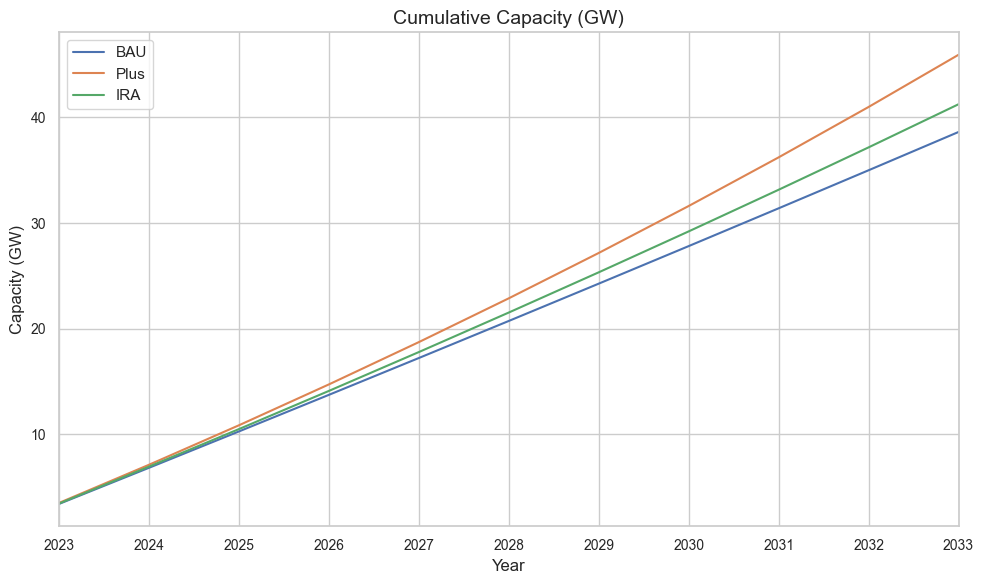

In [751]:
# Calculate the cumulative capacity for each scenario and year
total_capacity = predicted_generation_data[predicted_generation_data['year'] >= 2023].groupby(['year', 'scenario'])['kw'].sum()/1000000
total_capacity = total_capacity.groupby('scenario').cumsum()
print(total_capacity.head)

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot average adoption rates for each scenario
for scenario in total_capacity.index.get_level_values('scenario').unique():
    ax.plot(total_capacity.loc[:, scenario])

# Customize gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('Year', fontsize=12)
plt.ylabel('Capacity (GW)', fontsize=12)
plt.title('Cumulative Capacity (GW)', fontsize=14)

# Customize font size for tick labels and legend
plt.xticks(total_generation.index.get_level_values('year').unique(), fontsize=10)  # Set xticks with integer values
plt.yticks(fontsize=10)
plt.xlim(2023, 2033)
ax.legend(labels=['BAU', 'Plus', 'IRA'])
# plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

<bound method NDFrame.head of year    scenario
2010.0  bau           19.380994
2011.0  bau           32.380428
2012.0  bau           96.117435
2013.0  bau          214.898237
2014.0  bau          343.053810
2015.0  bau          743.207218
2016.0  bau          985.270122
2017.0  bau          756.321455
2018.0  bau          722.637466
2019.0  bau          954.803270
2020.0  bau          985.977538
2021.0  bau         4393.456444
2022.0  bau         4393.456444
2023.0  bau         4422.202362
        high        4546.768006
        med         4470.112225
2024.0  bau         4451.163874
        high        4706.212031
        med         4548.301122
2025.0  bau         4480.342598
        high        4872.033817
        med         4628.053797
2026.0  bau         4509.740162
        high        5044.488474
        med         4709.401525
2027.0  bau         4539.358208
        high        5223.841318
        med         4792.376208
2028.0  bau         4569.198389
        high        5410.

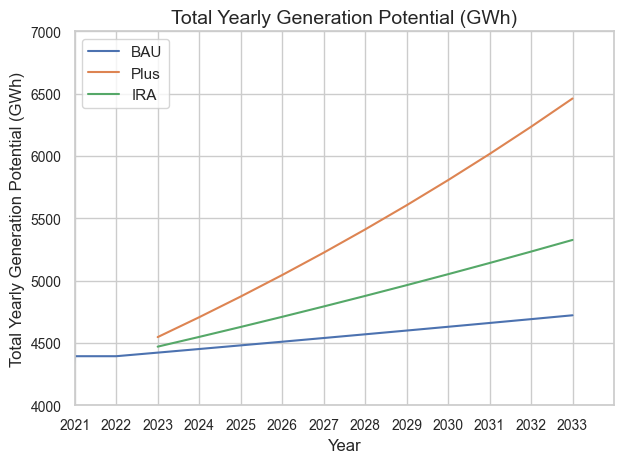

In [749]:
# Calculate the total generation potential for each scenario and year
total_generation = predicted_generation_data.groupby(['year', 'scenario'])['yearly_kwh'].sum()/1000000

print(total_generation.head)

# Create a figure and axis for the plot
# plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot average adoption rates for each scenario
for scenario in total_generation.index.get_level_values('scenario').unique():
    ax.plot(total_generation.loc[:, scenario])

# Customize gridlines
# ax.yaxis.grid(True)
# ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Yearly Generation Potential (GWh)', fontsize=12)
plt.title('Total Yearly Generation Potential (GWh)', fontsize=14)

# Customize font size for tick labels and legend
plt.xticks(total_generation.index.get_level_values('year').unique(), fontsize=10)  # Set xticks with integer values
plt.xlim(2021, 2034)
plt.ylim(4000, 7000)
plt.yticks(fontsize=10)
ax.legend(labels=['BAU', 'Plus', 'IRA'])
# plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

year    scenario
2023.0  bau          4422.202362
        high         4546.768006
        med          4470.112225
2024.0  bau          8873.366236
        high         9252.980037
        med          9018.413347
2025.0  bau         13353.708833
        high        14125.013854
        med         13646.467143
2026.0  bau         17863.448995
        high        19169.502328
        med         18355.868668
2027.0  bau         22402.807203
        high        24393.343646
        med         23148.244876
2028.0  bau         26972.005592
        high        29803.711922
        med         28025.255260
2029.0  bau         31571.267963
        high        35408.068233
        med         32988.592504
2030.0  bau         36200.819797
        high        41214.172101
        med         38039.983145
2031.0  bau         40860.888264
        high        47230.093428
        med         43181.188252
2032.0  bau         45551.702239
        high        53464.224913
        med         48414.

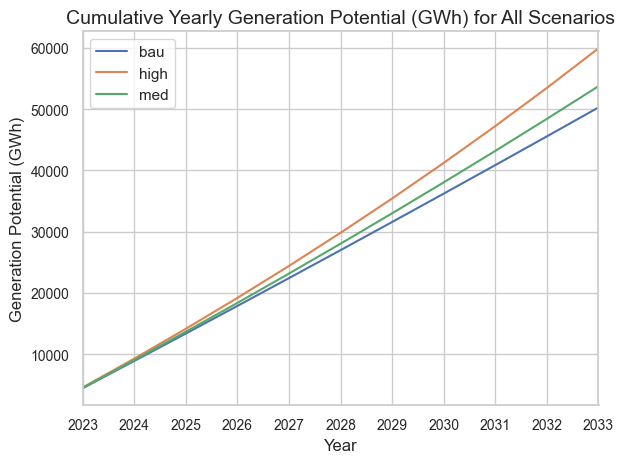

In [728]:
# Calculate the cumulative generation potential for each scenario and year
total_generation = predicted_generation_data[predicted_generation_data['year'] >= 2023].groupby(['year', 'scenario'])['yearly_kwh'].sum()/1000000
total_generation = total_generation.groupby('scenario').cumsum()
print(total_generation)

# Create a figure and axis for the plot
# plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot average adoption rates for each scenario
for scenario in total_generation.index.get_level_values('scenario').unique():
    ax.plot(total_generation.loc[:, scenario], label=scenario)

# Customize gridlines
# ax.yaxis.grid(True)
# ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('Year', fontsize=12)
plt.ylabel('Generation Potential (GWh)', fontsize=12)
plt.title('Cumulative Yearly Generation Potential (GWh) for All Scenarios', fontsize=14)

# Customize font size for tick labels and legend
plt.xticks(total_generation.index.get_level_values('year').unique(), fontsize=10)  # Set xticks with integer values
plt.xlim(2023, 2033)
# plt.ylim(100, 200)
plt.yticks(fontsize=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [735]:
print(predicted_generation_data)

         index        GEOID    year   
0        18030   1001020200  2021.0  \
1        37012   1001020200  2022.0   
4        37013   1001020200  2023.0   
5       295769   1001020200  2023.0   
6       554525   1001020200  2023.0   
...        ...          ...     ...   
813275  554522  56025000901  2032.0   
813276  813278  56025000901  2032.0   
813277  295767  56025000901  2033.0   
813278  554523  56025000901  2033.0   
813279  813279  56025000901  2033.0   

                                          bin_description    pct     N   
0                                                     NaN    NaN   NaN  \
1                                                     NaN    NaN   NaN   
4                                                     NaN    NaN   NaN   
5                                                     NaN    NaN   NaN   
6                                                     NaN    NaN   NaN   
...                                                   ...    ...   ...   
813275  AMI B

In [740]:
#Drop unneeded columns
predicted_generation_data = predicted_generation_data.drop(columns=['bin_description', 'pct', 'N','total_pop'])
predicted_generation_data = predicted_generation_data.dropna(subset=['adoption_rate', 'year'])

# Write tracts data for further analysis
predicted_generation_data.to_csv("predicted_adoption_generation_data.csv")

#TODO: FIX this write outputs to file for further analysis and mapping
# tract_adoption_geodata = tracts_geodata.merge(predicted_generation_data, left_index=True, right_on="GEOID")
# tract_adoption_geodata.to_file('tract_adoption_data.geojson', driver='GeoJSON')


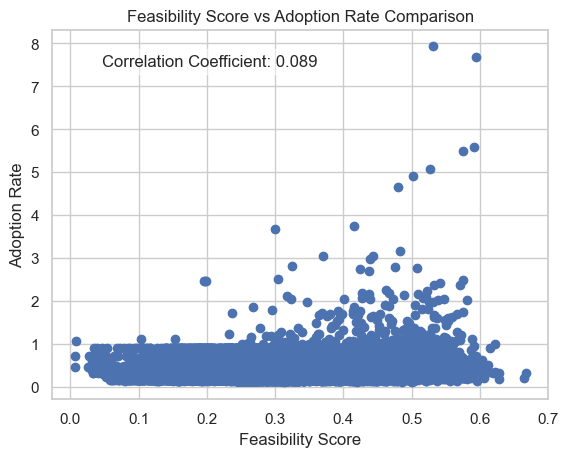

In [745]:
#Compare feasibility score with adoption rate 

## load MCDA Data
mcda_output = pd.read_csv("mcda_output.csv", index_col="GEOID")
mcda_output.index = mcda_output.index.astype(int)

threshold_max = 1 # Maximum acceptable value for 'adoption_rate'
threshold_min = 0 # Maximum acceptable value for 'adoption_rate'


adoption_2021 = predicted_adoption_data[(predicted_adoption_data['year'] == 2021)] 
# adoption_2021 = adoption_2021[(adoption_2021['adoption_rate'] < threshold_max) & (adoption_2021['adoption_rate'] > threshold_min)] 


merged_mcda_adoption = adoption_2021.merge(mcda_output, left_on="GEOID", right_index=True)

# print(merged_mcda_adoption['feasibility_score'].shape)
# print(adoption_2021.shape)
plt.scatter(merged_mcda_adoption['feasibility_score'], merged_mcda_adoption['adoption_rate'])
plt.xlabel('Feasibility Score')
plt.ylabel('Adoption Rate')
plt.title('Feasibility Score vs Adoption Rate Comparison')

correlation_coefficient = merged_mcda_adoption['feasibility_score'].corr(merged_mcda_adoption['adoption_rate'])
# Annotate the plot with the correlation coefficient
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()



In [568]:
#aggregate capacity at state and county levels to use for further analysis in next step
merged_adoption_data = cleaned_data[["state_abbr", "county_name"]].merge(predicted_scenario_data, left_index=True, right_on="GEOID")

tract_adoption_data = merged_adoption_data[['GEOID', 'state_abbr', 'county_name', 'year', 'scenario', 'adoption_rate', 'kw', 'yearly_kwh']]

#Write tracts data for further analysis
# tract_adoption_data.to_csv("tract_adoption_data.csv")

print(tract_adoption_data)

KeyError: "['state_abbr', 'county_name'] not in index"

In [567]:
#only want year 2024 for high scenario
med_2024_data = merged_adoption_data.loc[(merged_adoption_data['year'] == 2024) & (merged_adoption_data['scenario'] == 'med')]

print(merged_adoption_data.loc[(merged_adoption_data['year'] == 2021)].nlargest(10, 'adoption_rate')[["state_abbr", "county_name", "adoption_rate"]])


print("Top 10 Tracts for Solar Capacity (kw) 2024 Med:")
print(merged_adoption_data.loc[(merged_adoption_data['year'] == 2022) & (merged_adoption_data['scenario'] == 'high')].nlargest(10, 'kw')[["state_abbr", "county_name", "kw"]])

print("Top 10 Tracts for Solar Capacity (kw) 2024 High:")
print(merged_adoption_data.loc[(merged_adoption_data['year'] == 2024) & (merged_adoption_data['scenario'] == 'high')].nlargest(10, 'kw')[["state_abbr", "county_name", "kw"]])

KeyError: 'scenario'